##ドライブにマウント

In [ ]:
# Google ColabでGoogle Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##LigthGBM（データ加工済み+変数2つ消して2つ足した）

Original Shape: (10000, 15)
削除した列: ['education', 'fnlwgt']

--- 特徴量一覧 ---
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country', 'has_capital_gain', 'has_capital_loss', 'capital-gain-log', 'capital-loss-log']
特徴量の数: 14
カテゴリ変数: ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

--- LightGBM Training Start ---
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.947012	valid's auc: 0.923308
Early stopping, best iteration is:
[136]	train's auc: 0.953613	valid's auc: 0.923638

Validation AUC Score: 0.9236


<Figure size 1000x800 with 0 Axes>

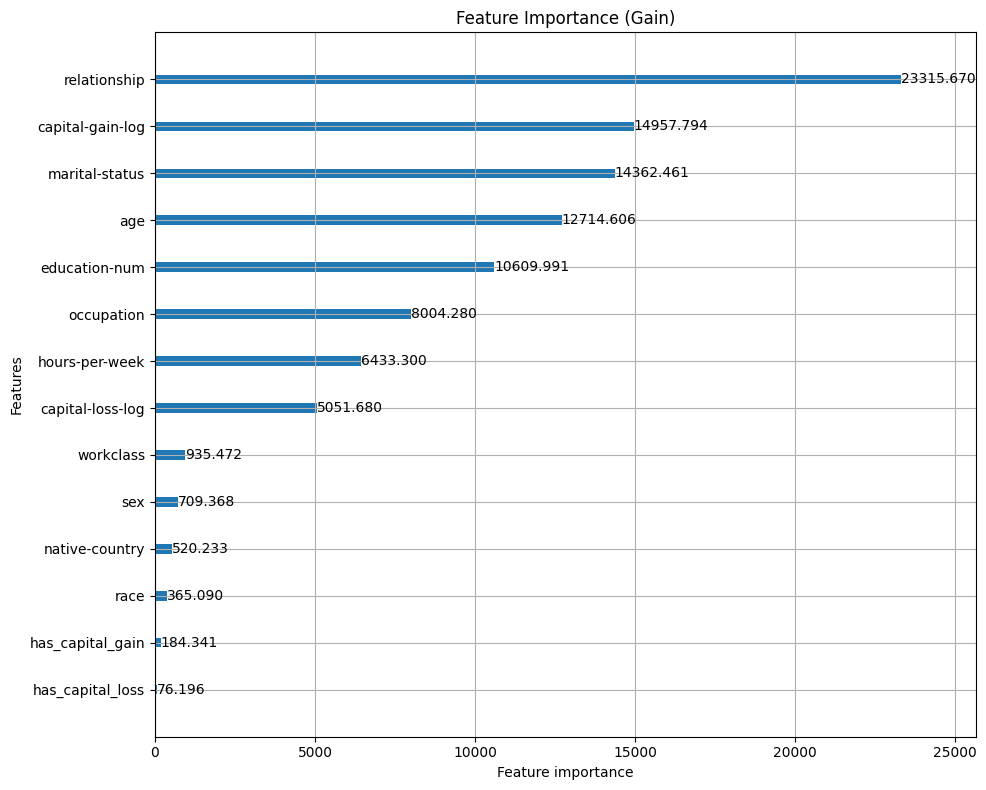

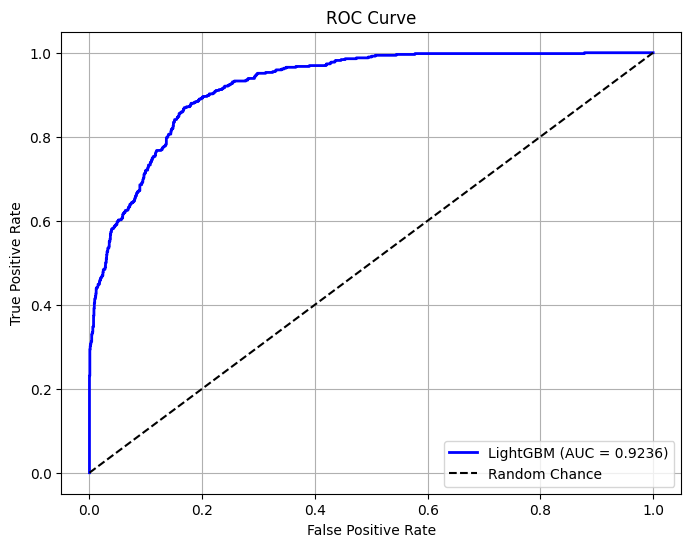

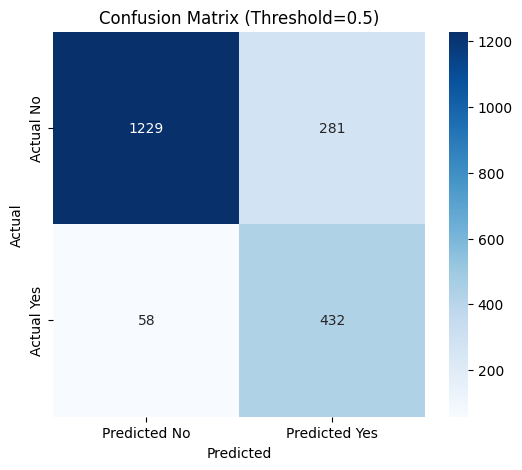


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88      1510
           1       0.61      0.88      0.72       490

    accuracy                           0.83      2000
   macro avg       0.78      0.85      0.80      2000
weighted avg       0.87      0.83      0.84      2000



In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

# ==========================================
# 1. データの読み込み
# ==========================================
file_path = '/content/drive/MyDrive/Team-Based-Project/data/train_test_2025.csv'

# encoding='shift_jis' を追加しました
try:
    df = pd.read_csv(file_path, encoding='shift_jis')
except UnicodeDecodeError:
    # shift_jisでダメなら cp932 (Windows拡張) を試す
    df = pd.read_csv(file_path, encoding='cp932')

print("Original Shape:", df.shape)

# ==========================================
# 2. 前処理 & 特徴量エンジニアリング
# ==========================================

# (1) 不要な列の削除
# 'education': 'education-num' (数値) と重複するため削除
# 'fnlwgt': サンプリング重みであり、個人の属性予測にはノイズとなるため削除
cols_to_drop = ['education', 'fnlwgt']

# データセットに実際に存在する列のみをリストアップして削除
existing_drop_cols = [c for c in cols_to_drop if c in df.columns]

if existing_drop_cols:
    df = df.drop(existing_drop_cols, axis=1)
    print(f"削除した列: {existing_drop_cols}")

# (2) 目的変数の変換 (yes -> 1, no -> 0)
target_col = 'ｙ'  # 全角の 'ｙ' に注意
if target_col in df.columns:
    df['target'] = df[target_col].map({'yes': 1, 'no': 0})
    df = df.drop(target_col, axis=1)
else:
    print(f"Warning: Target column '{target_col}' not found.")

# (3) Capital Gain / Loss の高度な加工 (LightGBM最適化)
# -------------------------------------------------------
# A. フラグ列の作成: 「そもそも投資/損失がある層か？」(0/1)
df['has_capital_gain'] = (df['capital-gain'] > 0).astype(int)
df['has_capital_loss'] = (df['capital-loss'] > 0).astype(int)

# B. 対数変換: 「規模はどれくらいか？」(対数)
# 0を0のまま扱える log1p を使用して、分布の歪みを補正します
df['capital-gain-log'] = np.log1p(df['capital-gain'])
df['capital-loss-log'] = np.log1p(df['capital-loss'])

# C. 元の列の削除
# フラグと対数変換で情報は十分なため、元の列は削除してモデルをスッキリさせます
df = df.drop(['capital-gain', 'capital-loss'], axis=1)
# -------------------------------------------------------

# (4) カテゴリ変数の処理
# education-num は「順序」が重要なので数値のまま残し、
# それ以外の名義尺度カテゴリだけを 'category' 型に変換します
cat_cols = ['workclass', 'marital-status', 'occupation',
            'relationship', 'race', 'sex', 'native-country']

# 実際に存在する列のみ変換
actual_cat_cols = [c for c in cat_cols if c in df.columns]
for col in actual_cat_cols:
    df[col] = df[col].astype('category')

print("\n--- 特徴量一覧 ---")
cols_list = df.drop('target', axis=1).columns.tolist()
print(cols_list)
print(f"特徴量の数: {len(cols_list)}")
print(f"カテゴリ変数: {actual_cat_cols}")

# ==========================================
# 3. データ分割 (Train / Validation)
# ==========================================
X = df.drop('target', axis=1)
y = df['target']

# 層化抽出 (stratify=y) で、学習・検証データの yes/no 比率を一定に保つ
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# LightGBMデータセットの作成
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=actual_cat_cols)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=actual_cat_cols, reference=train_data)

# ==========================================
# 4. モデル学習 (Training)
# ==========================================
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'is_unbalance': True,     # 【重要】不均衡データ対策
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,    # じっくり学習
    'num_leaves': 31,
    'random_state': 42
}

print("\n--- LightGBM Training Start ---")
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(100)
    ]
)

# ==========================================
# 5. 評価と可視化 (Evaluation)
# ==========================================
# 予測確率の算出
y_pred_prob = model.predict(X_val, num_iteration=model.best_iteration)

# (A) AUCスコア
auc_score = roc_auc_score(y_val, y_pred_prob)
print(f"\n========================================")
print(f"Validation AUC Score: {auc_score:.4f}")
print(f"========================================")

# (B) Feature Importance (重要度)
plt.figure(figsize=(10, 8))
lgb.plot_importance(model, importance_type='gain', max_num_features=20, title='Feature Importance (Gain)', figsize=(10, 8))
plt.tight_layout()
plt.show()

# (C) ROC曲線
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {auc_score:.4f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# (D) 混同行列 & レポート (閾値0.5)
y_pred_binary = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_val, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix (Threshold=0.5)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nClassification Report:")
print(classification_report(y_val, y_pred_binary))

正解がNoの人をyesと間違えて判定しがち

#optuna+交差検証+閾値の最適化

###optunaインストール

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.9 MB/s eta 0:00:00


#⬇️最終コード⬇️

# アンサンブル準備-3csv生成-

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, f1_score

# ==========================================
# 1. データの読み込み & ID付与
# ==========================================
file_path = '/content/drive/MyDrive/Team-Based-Project/data/train_test_2025.csv'

try:
    df = pd.read_csv(file_path, encoding='shift_jis')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='cp932')

# 【重要】インポート時にID付与
df['id'] = df.index
print("Original Shape:", df.shape)

# ==========================================
# 2. 前処理 & 特徴量エンジニアリング
# ==========================================
# (1) 不要な列の削除
cols_to_drop = ['education', 'fnlwgt']
existing_drop_cols = [c for c in cols_to_drop if c in df.columns]
if existing_drop_cols:
    df = df.drop(existing_drop_cols, axis=1)

# (2) 目的変数の変換 (yes -> 1, no -> 0)
target_col = 'ｙ'  # 全角ｙ
if target_col in df.columns:
    df['target'] = df[target_col].map({'yes': 1, 'no': 0})
    df = df.drop(target_col, axis=1)

# (3) 数値データの加工
df['has_capital_gain'] = (df['capital-gain'] > 0).astype(int)
df['has_capital_loss'] = (df['capital-loss'] > 0).astype(int)
df['capital-gain-log'] = np.log1p(df['capital-gain'])
df['capital-loss-log'] = np.log1p(df['capital-loss'])
df = df.drop(['capital-gain', 'capital-loss'], axis=1)

# (4) カテゴリ変数の型変換
cat_cols = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
actual_cat_cols = [c for c in cat_cols if c in df.columns]
for col in actual_cat_cols:
    df[col] = df[col].astype('category')

# ==========================================
# 3. データ分割 (Train / Val / ID保持)
# ==========================================
# 【重要】モデル学習時にはidを外すが、分割時にはidも一緒に分ける
X = df.drop(['target', 'id'], axis=1)
y = df['target']
ids = df['id']

# random_state=42, test_size=0.2 で固定
X_train, X_val, y_train, y_val, id_train, id_val = train_test_split(
    X, y, ids, test_size=0.2, random_state=42, stratify=y
)

# ==========================================
# 4. Optunaによるハイパーパラメータ自動探索
# ==========================================
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'is_unbalance': True,
        'random_state': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        train_data = lgb.Dataset(X_tr_cv, label=y_tr_cv, categorical_feature=actual_cat_cols)
        val_data = lgb.Dataset(X_val_cv, label=y_val_cv, categorical_feature=actual_cat_cols, reference=train_data)
        model = lgb.train(param, train_data, valid_sets=[val_data], callbacks=[lgb.early_stopping(20, verbose=False)])
        preds = model.predict(X_val_cv, num_iteration=model.best_iteration)
        auc_scores.append(roc_auc_score(y_val_cv, preds))
    return np.mean(auc_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# ==========================================
# 5. ベストモデルで再学習 & 閾値最適化
# ==========================================
best_params = study.best_params
best_params.update({'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'is_unbalance': True, 'random_state': 42})

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=actual_cat_cols)
final_model = lgb.train(best_params, lgb_train, num_boost_round=1000)

# 検証データでの予測
y_val_prob = final_model.predict(X_val)

# F1最大化による閾値最適化
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1, best_threshold = 0, 0.5
for th in thresholds:
    f1 = f1_score(y_val, (y_val_prob >= th).astype(int))
    if f1 > best_f1:
        best_f1, best_threshold = f1, th

# ==========================================
# 6. 検証用データの出力 (valid_prediction_gbm.csv)
# ==========================================
df_valid_output = pd.DataFrame({
    'id': id_val,
    'Actual': y_val,
    'GBM_Probability': y_val_prob,
    'GBM_Prediction': (y_val_prob >= best_threshold).astype(int)
})
valid_output_path = '/content/drive/MyDrive/Team-Based-Project/output/valid_prediction_gbm.csv'
df_valid_output.to_csv(valid_output_path, index=False)
print(f"検証用CSV保存完了: {valid_output_path}")

# ==========================================
# 7. 提出用データの予測 & 出力 (test_prediction_gbm.csv)
# ==========================================
submit_file_path = '/content/drive/MyDrive/Team-Based-Project/data/submit_2025.csv'
try:
    df_submit = pd.read_csv(submit_file_path, encoding='shift_jis')
except UnicodeDecodeError:
    df_submit = pd.read_csv(submit_file_path, encoding='cp932')

# ID付与
df_submit['id'] = df_submit.index
submit_ids = df_submit['id']

# 前処理 (学習時と同じ列構成にする)
df_submit_proc = df_submit.copy()
df_submit_proc['has_capital_gain'] = (df_submit_proc['capital-gain'] > 0).astype(int)
df_submit_proc['has_capital_loss'] = (df_submit_proc['capital-loss'] > 0).astype(int)
df_submit_proc['capital-gain-log'] = np.log1p(df_submit_proc['capital-gain'])
df_submit_proc['capital-loss-log'] = np.log1p(df_submit_proc['capital-loss'])

for col in actual_cat_cols:
    if col in df_submit_proc.columns:
        df_submit_proc[col] = df_submit_proc[col].astype('category')

# 学習に使った特徴量のみに絞る
df_submit_proc = df_submit_proc[X_train.columns]

# 予測
submit_probs = final_model.predict(df_submit_proc)

# 指定形式で保存 (id, 確率, 0/1判定)
df_submit_output = pd.DataFrame({
    'id': submit_ids,
    'GBM_Probability': submit_probs,
    'GBM_Prediction': (submit_probs >= best_threshold).astype(int)
})

submit_output_path = '/content/drive/MyDrive/Team-Based-Project/output/test_prediction_gbm.csv'
df_submit_output.to_csv(submit_output_path, index=False)
print(f"提出用CSV保存完了: {submit_output_path}")

[I 2025-12-18 15:58:37,390] A new study created in memory with name: no-name-a445ecc8-4159-4eca-90e1-e2b08df35b57


Original Shape: (10000, 16)


[I 2025-12-18 15:58:38,210] Trial 0 finished with value: 0.9142994408028111 and parameters: {'learning_rate': 0.07080883541994117, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 26, 'reg_alpha': 0.13838586345373305, 'reg_lambda': 0.2846226129971341, 'subsample': 0.9558341716276565, 'colsample_bytree': 0.5936548652342667}. Best is trial 0 with value: 0.9142994408028111.
[I 2025-12-18 15:58:38,995] Trial 1 finished with value: 0.9099648178807946 and parameters: {'learning_rate': 0.048187457785365914, 'num_leaves': 110, 'max_depth': 11, 'min_child_samples': 71, 'reg_alpha': 0.722125209688824, 'reg_lambda': 0.90783037752888, 'subsample': 0.5992680837270229, 'colsample_bytree': 0.8064542304834916}. Best is trial 0 with value: 0.9142994408028111.
[I 2025-12-18 15:58:39,689] Trial 2 finished with value: 0.906669186714421 and parameters: {'learning_rate': 0.023623604003371976, 'num_leaves': 145, 'max_depth': 7, 'min_child_samples': 28, 'reg_alpha': 0.474489913538087, 'reg_lambda': 0.7

検証用CSV保存完了: /content/drive/MyDrive/Team-Based-Project/output/valid_prediction_gbm.csv
提出用CSV保存完了: /content/drive/MyDrive/Team-Based-Project/output/test_prediction_gbm.csv



★ Validation AUC Score: 0.9097


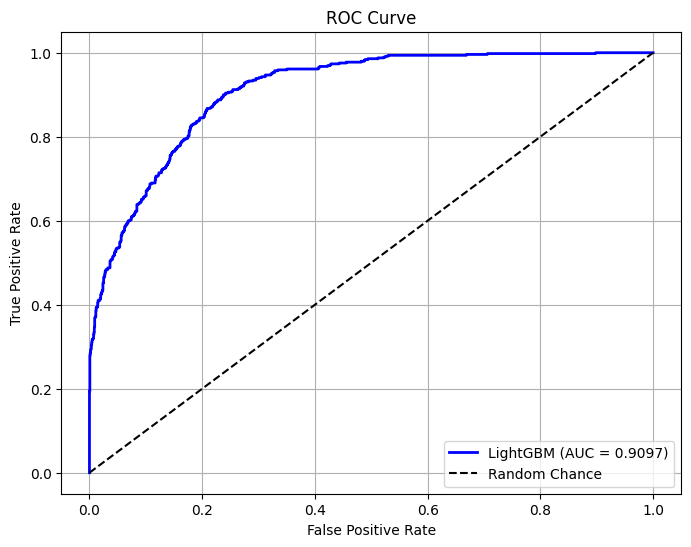

<Figure size 1000x800 with 0 Axes>

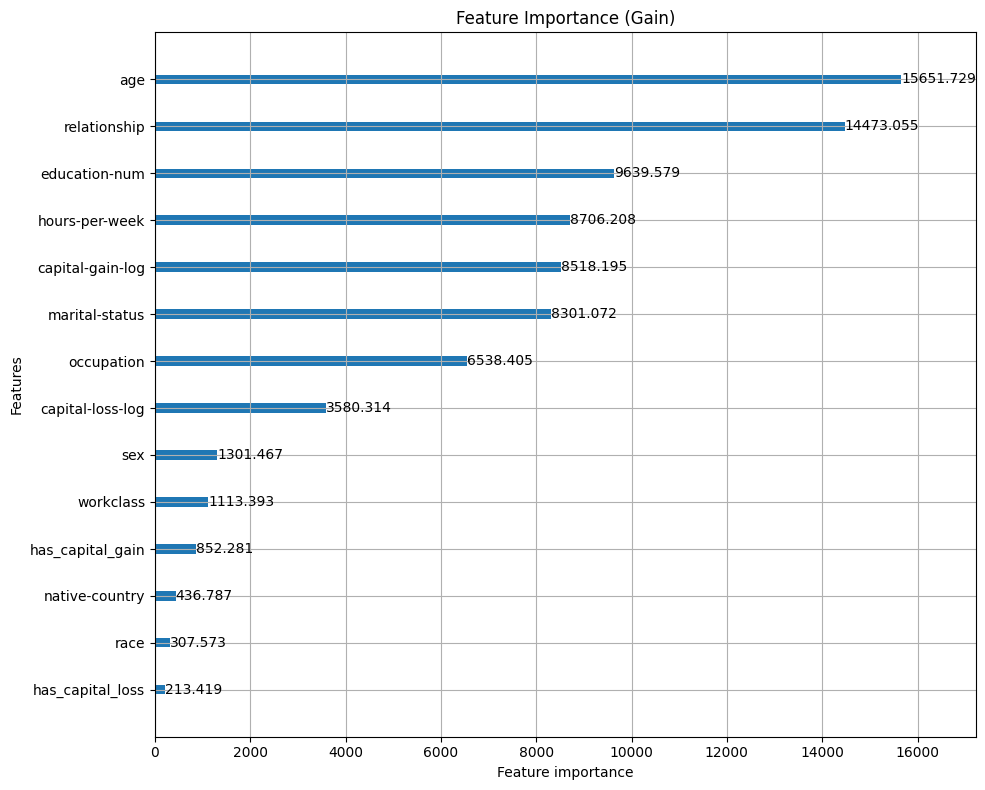

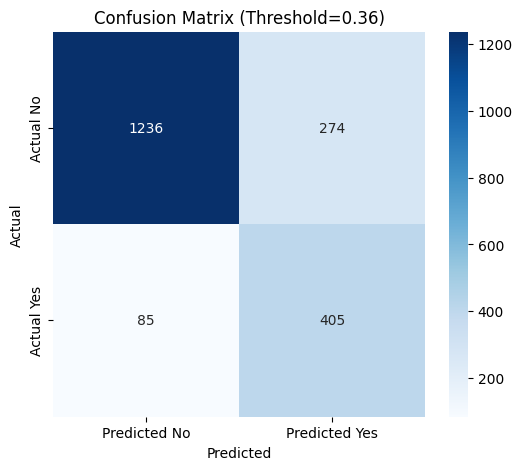


Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.94      0.82      0.87      1510
           1       0.60      0.83      0.69       490

    accuracy                           0.82      2000
   macro avg       0.77      0.82      0.78      2000
weighted avg       0.85      0.82      0.83      2000


★ 最終提出ファイル保存完了: /content/drive/MyDrive/Team-Based-Project/output/submit_prediction_lightgbm.csv
データの形状: (1000, 16)
使用した閾値: 0.3600

--- 作成データのプレビュー (右端の列を確認) ---
     ｙ  probability of yes (or score)
0   no                       0.120317
1  yes                       0.744792
2   no                       0.000026
3   no                       0.000635
4  yes                       0.903184


In [ ]:
# ==========================================
# 8. モデル評価と可視化 (AUC, 重要変数, 混同行列)
# ==========================================
# 検証データ (X_val, y_val) に対する予測結果 (y_val_prob) を使用します

# ---------------------------------------------------------
# (A) ROC曲線とAUC (Area Under the Curve)
# ---------------------------------------------------------
auc_score = roc_auc_score(y_val, y_val_prob)
print(f"\n★ Validation AUC Score: {auc_score:.4f}")

fpr, tpr, _ = roc_curve(y_val, y_val_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {auc_score:.4f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# (B) 重要変数の特定 (Feature Importance)
# ---------------------------------------------------------
# gain: 分岐による目的関数の減少量（予測への貢献度）
plt.figure(figsize=(10, 8))
lgb.plot_importance(final_model, importance_type='gain', max_num_features=20,
                    title='Feature Importance (Gain)', figsize=(10, 8))
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# (C) 混同行列・Recall・Precision・F値
# ---------------------------------------------------------
# 最適化された閾値 (best_threshold) で 0/1 を判定
y_val_pred = (y_val_prob >= best_threshold).astype(int)

# 混同行列 (Confusion Matrix)
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title(f'Confusion Matrix (Threshold={best_threshold:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 詳細レポート (Recall, Precision, F1-score)
print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_val, y_val_pred))


# ==========================================
# 9. 最終提出ファイルの作成 (submit_prediction_lightgbm.csv)
# ==========================================
# ステップ7で読み込んだ df_submit をコピーして使用します
# ステップ7で計算した submit_probs (確率) を使用します

output_file_path = '/content/drive/MyDrive/Team-Based-Project/output/submit_prediction_lightgbm.csv'

# 1. 元のテストデータをコピー (全列保持)
df_final_submit = df_submit.copy()

# 2. 確率の代入 ('probability of yes (or score)')
df_final_submit['probability of yes (or score)'] = submit_probs

# 3. 予測ラベルの代入 ('ｙ')
# 閾値判定 -> 数値(1/0) -> 文字列('yes'/'no')
pred_binary = (submit_probs >= best_threshold).astype(int)
df_final_submit['ｙ'] = pred_binary
df_final_submit['ｙ'] = df_final_submit['ｙ'].map({1: 'yes', 0: 'no'})

# ---------------------------------------------------------
# ★ ここに追加: id列を削除
# ---------------------------------------------------------
df_final_submit = df_final_submit.drop(columns=['id'], errors='ignore')

# 4. ファイル保存
df_final_submit.to_csv(output_file_path, index=False, encoding='shift_jis')

print("\n========================================")
print(f"★ 最終提出ファイル保存完了: {output_file_path}")
print(f"データの形状: {df_final_submit.shape}")
print(f"使用した閾値: {best_threshold:.4f}")
print("\n--- 作成データのプレビュー (右端の列を確認) ---")
print(df_final_submit[['ｙ', 'probability of yes (or score)']].head())
print("========================================")

##補足で

In [ ]:
# ==========================================
# 8. SHAP値によるモデルの解釈 (Explainability)
# ==========================================
# ★ライブラリがない場合はインストールしてください: !pip install shap
import shap

print("\n--- SHAP Value Calculation Start (これには数分かかる場合があります) ---")

# SHAP Explainerの作成
explainer = shap.TreeExplainer(final_model)

# テストデータに対するSHAP値を計算
# (データ量が多いと時間がかかるため、ランダムに1000件サンプリングしてもOKですが、今回は全件やります)
shap_values = explainer.shap_values(X_test)

# LightGBMのバージョンによって戻り値の形式が異なる場合の対応
# (2クラス分類の場合、shap_values[1] が 'Yes' クラスへの貢献度)
if isinstance(shap_values, list):
    shap_values_target = shap_values[1]
else:
    shap_values_target = shap_values

# (A) Summary Plot (全体像)
# どの特徴量が、どのように予測値を押し上げた/下げたかが一目でわかります
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values_target, X_test, show=False)
plt.title("SHAP Summary Plot", fontsize=16)
plt.show()

# (B) Dependence Plot (特定の特徴量の深掘り)
# 例: 年齢(age)が予測にどう影響しているか？ (横軸: 年齢, 縦軸: SHAP値)
# 赤い色は、交差作用(Interaction)が強い別の変数を示します
target_feature = 'age'
if target_feature in X_test.columns:
    shap.dependence_plot(target_feature, shap_values_target, X_test, show=False)
    plt.title(f"SHAP Dependence Plot: {target_feature}", fontsize=16)
    plt.show()

print("★ SHAP分析完了: 赤い点(High)が右側にあれば、その値が高いほどYesになりやすいことを示します。")

SyntaxError: invalid syntax (ipython-input-2461008995.py, line 10)